In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, brier_score_loss,
    precision_recall_curve, auc, classification_report
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance

In [ ]:
# 1. Load Data
df = pd.read_csv("merged_output (2).csv", parse_dates=['date'])
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['year'] = df['date'].dt.year

# 2. Define Target and Features
target = 'fire'
features = [c for c in df.columns if c not in ['index', 'date', 'year', target]]

In [ ]:
# 3. Balance Classes per Year with SMOTE
balanced_frames = []
sm = SMOTE(k_neighbors=3, random_state=42)

for year, grp in df.groupby('year'):
    X_grp = grp[features]
    y_grp = grp[target]
    if y_grp.nunique() < 2:
        continue
    try:
        X_res, y_res = sm.fit_resample(X_grp, y_grp)
        df_res = pd.DataFrame(X_res, columns=features)
        df_res[target] = y_res
        df_res['year'] = year
        balanced_frames.append(df_res)
    except ValueError:
        continue

In [ ]:
df_balanced = pd.concat(balanced_frames, ignore_index=True).sample(frac=1, random_state=42)

# 4. Train-Test Split
X = df_balanced[features]
y = df_balanced[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
y_train.value_counts()

,count
fire,
1,15470
0,15470


In [ ]:
y_test.value_counts()

,count
fire,
1,3868
0,3868


In [ ]:
# 5. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 6. Initialize XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [ ]:
# 7. Hyperparameter Grid (comprehensive)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'min_child_weight': [1, 5],
    'scale_pos_weight': [1],  # SMOTE already handled imbalance
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search.fit(X_train_scaled, y_train)
best_xgb = grid_search.best_estimator_
print("Best XGBoost Parameters:")
print(grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best XGBoost Parameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}


In [ ]:
# 8. Calibrate the Best Model
calibrated_xgb = CalibratedClassifierCV(best_xgb, method='isotonic', cv=5)
calibrated_xgb.fit(X_train_scaled, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1.0,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=1, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...),
                       method='isotonic')

In [ ]:
# 9. Predictions
probs = calibrated_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred = calibrated_xgb.predict(X_test_scaled)

In [ ]:
# 10. Evaluation
roc = roc_auc_score(y_test, probs)
brier = brier_score_loss(y_test, probs)
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

print(f"\n📊 Evaluation Metrics:")
print(f"ROC-AUC Score     : {roc:.4f}")
print(f"PR-AUC Score      : {pr_auc:.4f}")
print(f"Brier Score       : {brier:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



📊 Evaluation Metrics:
ROC-AUC Score     : 0.9868
PR-AUC Score      : 0.9859
Brier Score       : 0.0413

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3868
           1       0.94      0.95      0.95      3868

    accuracy                           0.95      7736
   macro avg       0.95      0.95      0.95      7736
weighted avg       0.95      0.95      0.95      7736



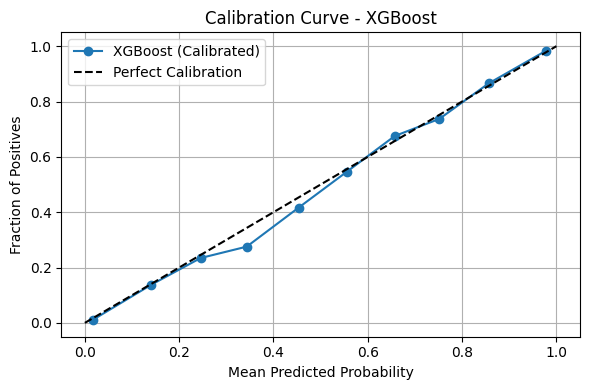

In [ ]:
# 11. Calibration Curve
true_prob, pred_prob = calibration_curve(y_test, probs, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(pred_prob, true_prob, marker='o', label='XGBoost (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

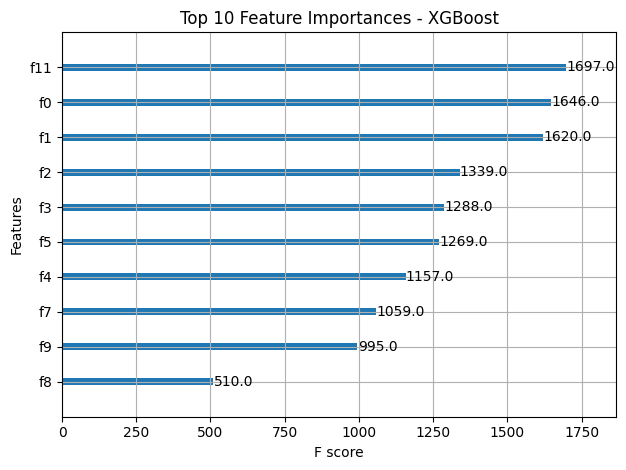

In [ ]:
# 12. Feature Importance Plot
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10)
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

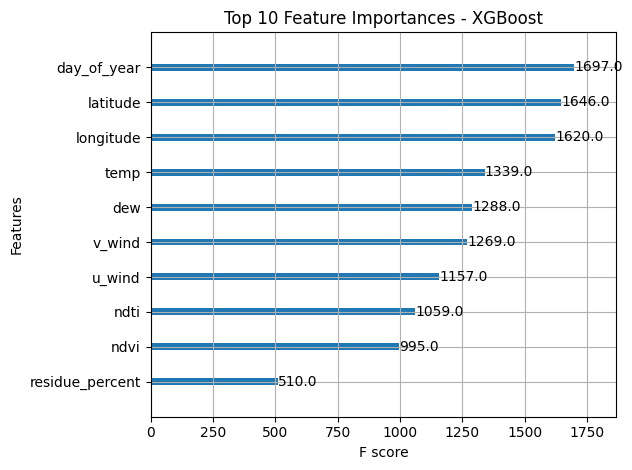

In [ ]:
import xgboost as xgb
import pandas as pd

# 1. Get original feature names
feature_names = X_train.columns.tolist()

# 2. Assign to booster manually
best_xgb.get_booster().feature_names = feature_names

# 3. Plot importance
xgb.plot_importance(best_xgb, max_num_features=10)
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


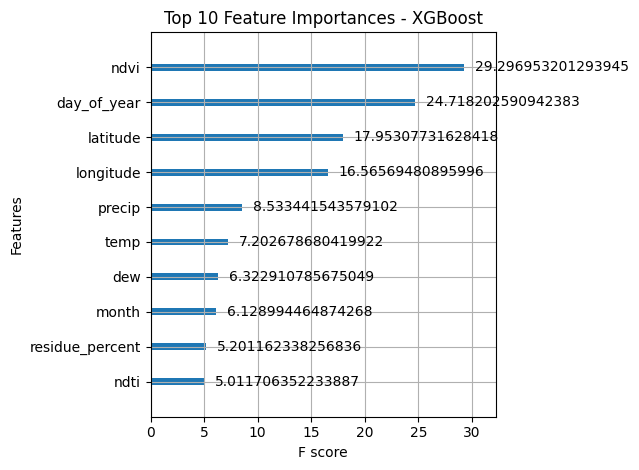

In [ ]:
import xgboost as xgb
import pandas as pd

# 1. Get original feature names
feature_names = X_train.columns.tolist()

# 2. Assign to booster manually
best_xgb.get_booster().feature_names = feature_names

# 3. Plot importance
xgb.plot_importance(best_xgb, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()


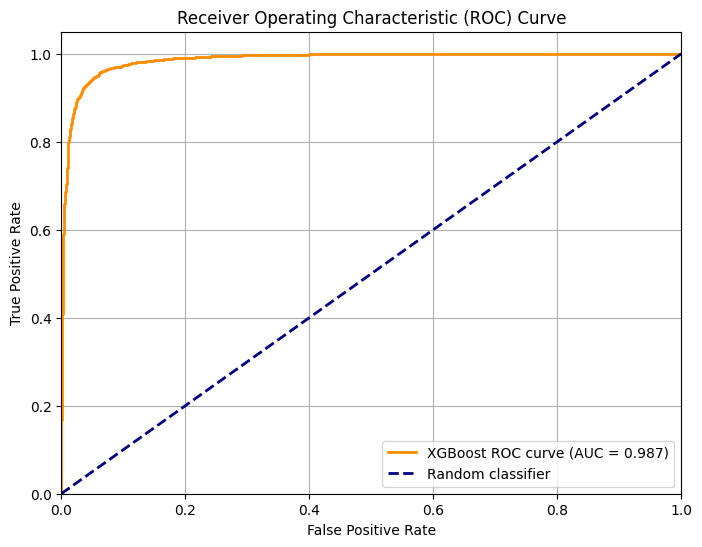

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assume X_test_scaled and y_test are your test data and labels
# probs = predicted probabilities from XGBoost (for the positive class)
probs = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
